### Introduction

In this notebook, we will explore data through the process of feature selection and model testing. The aim is to identify the most relevant features and evaluate different machine learning models to understand their performance with the given dataset. We will implement various feature selection techniques and test multiple models to optimize performance, ensuring that the selected features contribute to the model's predictive accuracy.

### Step 1: Data Exploration and Preprocessing

In the first step, we will perform an initial exploration of the dataset. This involves:

1. **Loading the Data**: We will import the dataset and familiarize ourselves with its structure, including data types and missing values.
2. **Feature Selection**: We will explore the features using correlation analysis, variance thresholds, and other techniques to identify the most important features for the models.
3. **Encoding Categorical Data**: For categorical variables such as team names, we will apply **one-hot encoding** to transform these features into a format suitable for machine learning models, ensuring they can be effectively used in the analysis.

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

with open('../CleanData/all_players_df.pkl', 'rb') as file:
    data = pickle.load(file)

# Display basic information about the DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968 entries, 0 to 967
Data columns (total 69 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   player_name                                968 non-null    object 
 1   real_name                                  968 non-null    object 
 2   team                                       968 non-null    object 
 3   age                                        968 non-null    int64  
 4   rating                                     968 non-null    float64
 5   dpr                                        968 non-null    float64
 6   kpr                                        968 non-null    float64
 7   kast                                       968 non-null    float64
 8   impact                                     968 non-null    float64
 9   adr                                        968 non-null    float64
 10  rating_is_missing         

In [2]:
# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

Categorical columns: Index(['player_name', 'real_name', 'team'], dtype='object')


In [3]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(data[categorical_columns])

In [4]:
# Get the new column names
encoded_column_names = encoder.get_feature_names_out(categorical_columns)

# Create a new DataFrame with the encoded variables
encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)

display(encoded_df.head())

,player_name_0i,player_name_1962,player_name_1uke,player_name_ADDICT,player_name_AJTT,player_name_ALEX,player_name_ALLE,player_name_AMANEK,player_name_ANDROID,player_name_ANGE1,...,team_vibe,team_vikings kr,team_virtus.pro,team_vitality,team_vp.prodigy,team_w7m,team_wildcard,team_wopa,team_xi b,team_zero tenacity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Concatenate the encoded DataFrame with the original numeric data
numeric_data = data.select_dtypes(include=['int64', 'float64'])
final_data = pd.concat([numeric_data, encoded_df], axis=1)

print("Shape of final dataset:", final_data.shape)
print("\nFirst few columns of encoded data:")
print(final_data.head())

Shape of final dataset: (968, 2184)

First few columns of encoded data:
   age    rating       dpr       kpr      kast    impact       adr  \
0   23  1.000000  0.333333  0.966667  0.924370  1.000000  0.855263   
1   23  0.627451  0.476190  0.600000  0.663866  0.529412  0.549342   
2   23  0.588235  0.428571  0.500000  0.747899  0.441176  0.536184   
3   23  0.607843  0.571429  0.500000  0.689076  0.602941  0.549342   
4   23  0.372549  0.714286  0.466667  0.352941  0.455882  0.523026   

   total_kills  total_deaths  rounds_played  ...  team_vibe  team_vikings kr  \
0     0.535451      0.360651       0.419567  ...        0.0              0.0   
1     0.181227      0.141909       0.152015  ...        0.0              0.0   
2     0.208649      0.180832       0.196674  ...        0.0              0.0   
3     0.156083      0.141453       0.138413  ...        0.0              0.0   
4     0.838105      0.891845       0.873289  ...        0.0              0.0   

   team_virtus.pro  team_v

In [6]:
# Rating is our target variable
X = final_data.drop('rating', axis=1)
y = final_data['rating']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Correlation Analysis
correlation_with_target = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print("Top 10 features correlated with the target:")
print(correlation_with_target.head(10))

c:\Users\Chaos\anaconda3\envs\dev\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Chaos\anaconda3\envs\dev\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Top 10 features correlated with the target:
kd_ratio                            0.865731
kpr                                 0.848259
kills_per_round                     0.848259
firepower_score                     0.809547
firepower_rounds_with_kill          0.780514
impact                              0.779828
firepower_kills_per_round           0.779659
firepower_rounds_with_multi_kill    0.760323
opening_success                     0.723306
kast                                0.697556
dtype: float64


In [8]:
# Feature Importance from Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 important features from Random Forest:")
print(feature_importance.head(10))


Top 10 important features from Random Forest:
                                    feature  importance
9                                  kd_ratio    0.631984
23           firepower_damage_per_round_win    0.104499
11                          kills_per_round    0.039259
2                                       kpr    0.035671
19                          firepower_score    0.024852
4                                    impact    0.018439
50                  trading_damage_per_kill    0.016728
3                                      kast    0.011603
45                  entrying_support_rounds    0.010832
63  utility_time_opponent_flashed_per_round    0.009248


In [9]:
# Create a copy of the dataframe for PCA
pca_df = final_data.copy()

# Ensure 'rating' is not in the feature set for PCA
X_pca = pca_df.drop('rating', axis=1)
y_pca = pca_df['rating']

In [10]:
#Prepare Data for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

print("Shape of scaled feature matrix:", X_scaled.shape)

Shape of scaled feature matrix: (968, 2183)


In [11]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

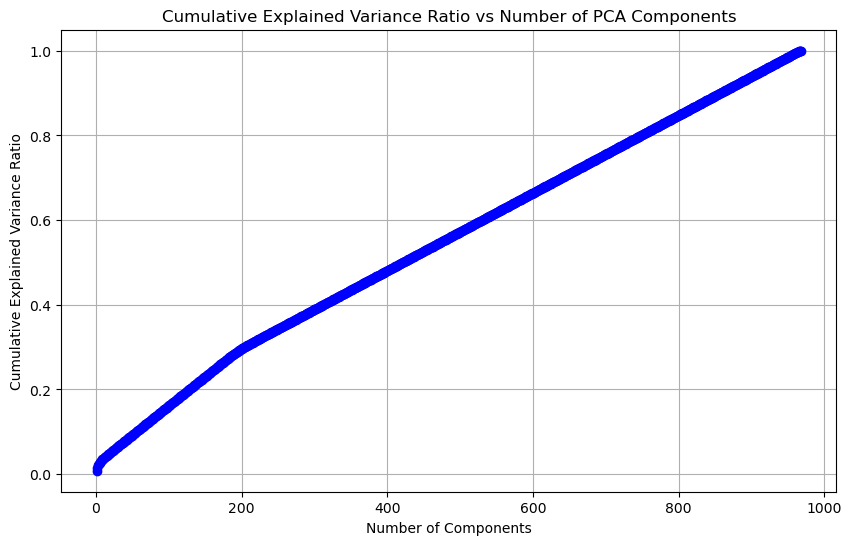

In [12]:
# Plot cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs Number of PCA Components')
plt.grid(True)
plt.show()

In [13]:
# Find number of components for 95% variance explained
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components explaining 95% of variance: {n_components_95}")

# Perform PCA with 95% explained variance
pca_95 = PCA(n_components=n_components_95)
X_pca_95 = pca_95.fit_transform(X_scaled)

print(f"Shape of PCA-transformed data (95% variance): {X_pca_95.shape}")

Number of components explaining 95% of variance: 912
Shape of PCA-transformed data (95% variance): (968, 912)


In [14]:
# Get feature names
feature_names = X.columns

# Create a DataFrame of feature loadings
loadings = pd.DataFrame(
    pca_95.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components_95)],
    index=feature_names
)

# Print the top 10 features for the first 3 principal components
for i in range(3):
    print(f"\nTop 10 features in PC{i+1}:")
    print(loadings[f'PC{i+1}'].abs().sort_values(ascending=False).head(10))


Top 10 features in PC1:
sniping_rounds_with_kills_percentage    0.206995
sniping_kills_per_round                 0.205665
sniping_multi_kill_rounds               0.205606
sniping_score                           0.204642
sniping_kills_percentage                0.204071
opening_success                         0.202675
sniping_opening_kills_per_round         0.200080
kd_ratio                                0.191628
dpr                                     0.174935
deaths_per_round                        0.174935
Name: PC1, dtype: float64

Top 10 features in PC2:
firepower_damage_per_round_win      0.211863
trading_saved_teammate_per_round    0.198386
firepower_rounds_with_multi_kill    0.197993
damage_per_round                    0.197917
adr                                 0.197917
firepower_kills_per_round           0.197358
firepower_score                     0.194798
firepower_damage_per_round          0.190906
trading_kills_per_round             0.188715
firepower_rounds_with_kill   

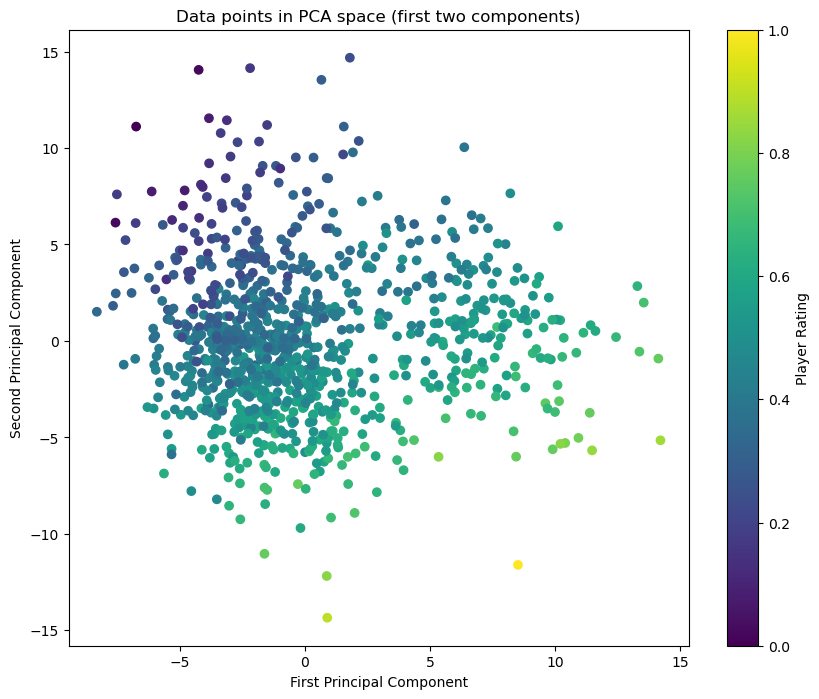

In [15]:
# Visualize the data points in PCA space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_95[:, 0], X_pca_95[:, 1], c=y, cmap='viridis')
plt.colorbar(scatter, label='Player Rating')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Data points in PCA space (first two components)')
plt.show()

In [16]:
# Calculate correlations between PCA components and target
pca_df = pd.DataFrame(X_pca_95, columns=[f'PC{i+1}' for i in range(n_components_95)])
pca_df['rating'] = y

correlations = pca_df.corr()['rating'].abs().sort_values(ascending=False)
print("\nCorrelations between PCA components and player rating:")
print(correlations.head(10))  # Print top 10 correlations


Correlations between PCA components and player rating:
rating    1.000000
PC2       0.735928
PC1       0.540888
PC8       0.131716
PC205     0.082638
PC11      0.079604
PC10      0.076846
PC201     0.069968
PC203     0.069323
PC3       0.068708
Name: rating, dtype: float64
